## Convert a .dat file to a .csv file.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import csv


dat_file_path = "/content/gdrive/MyDrive/Experimenter_9110002_53.dat"
csv_file_path = "/content/gdrive/MyDrive/output.csv"

with open(dat_file_path, 'r') as dat_file:
    with open(csv_file_path, 'w', newline='') as csv_file:
        csv_writer = csv.writer(csv_file)

        for line in dat_file:
            data = line.strip().split()
            csv_writer.writerow(data)


## Data preprocessing

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('/content/gdrive/MyDrive/output.csv')
df = df.loc[:, df.nunique() > 1]

## Data summary

In [4]:
for column in df.columns:
    print(df[column].describe())
    print()


count    27750.000000
mean       231.256292
std        133.514130
min          0.016000
25%        115.635250
50%        231.256000
75%        346.876750
max        462.497000
Name: DatTime, dtype: float64

count    27750.000000
mean       231.865946
std        133.515365
min          0.133333
25%        116.241550
50%        231.866435
75%        347.491320
max        463.099537
Name: MediaTime, dtype: float64

count    27750.000000
mean        -0.000001
std          0.001728
min         -0.026851
25%         -0.000185
50%          0.000000
75%          0.000150
max          0.029352
Name: LonAccel, dtype: float64

count    27750.000000
mean        -0.000003
std          0.006029
min         -0.052402
25%         -0.000230
50%         -0.000013
75%          0.000063
max          0.090595
Name: LatAccel, dtype: float64

count    27750.000000
mean         9.826212
std          6.416491
min          1.225370
25%          6.148331
50%          9.736254
75%         13.324176
max         29

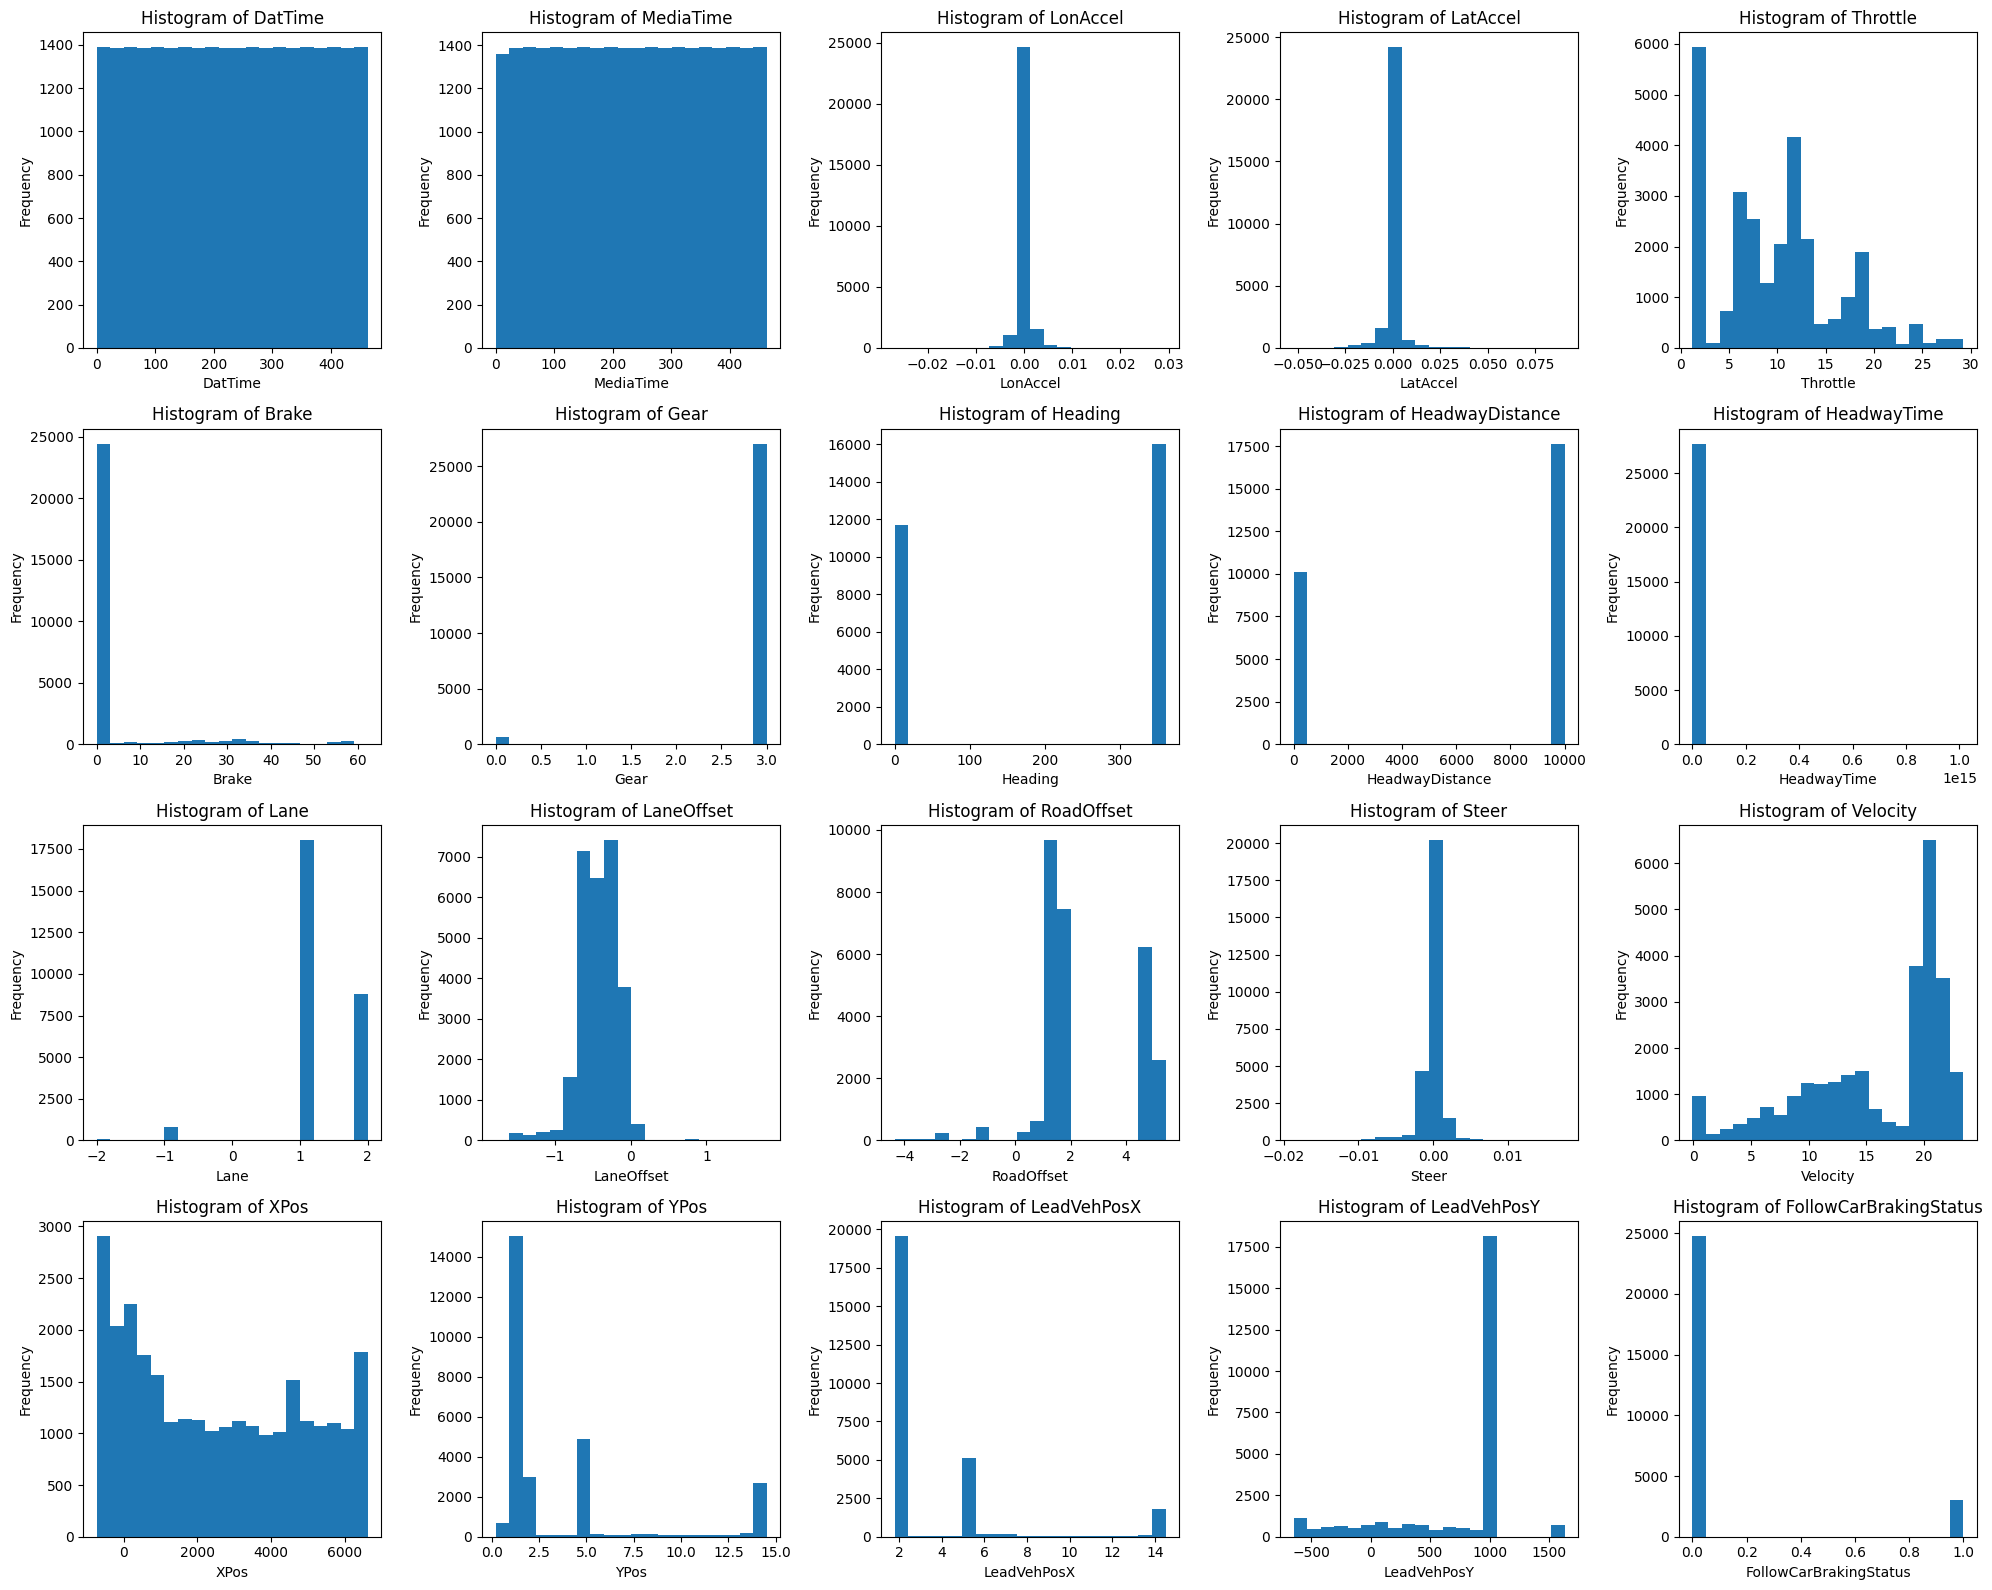

In [5]:
n_cols = 5
# Ensure there are enough rows to display all columns
n_rows = (len(df.columns) + n_cols - 1) // n_cols

# Adjust the figsize parameter to display the charts appropriately
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))

# Iterate over all columns, and plot a histogram on the corresponding subplot
for i, column in enumerate(df.columns):
    ax = axes[i // n_cols, i % n_cols]
    df[column].plot(kind='hist', bins=20, title=f'Histogram of {column}', ax=ax)
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')

# If the number of columns is not divisible by n_cols, hide the extra subplots
for j in range(i + 1, n_rows * n_cols):
    axes.flatten()[j].set_visible(False)  # This should likely be False to hide extra subplots

plt.tight_layout()
plt.show()


## 1) How risky the driver is

This notebook evaluates the risk of a driver's behavior through four criteria:
1.  Whether the car is moving too fast when turning.
2. Whether the car brakes abruptly in high speed or non-straight situations.
3. Whether the car's speed matches its gear.
4. Whether the car's position is too far from the center of the lane.

The first two behaviors may lead to decreased vehicle control and rollovers. The third behavior may cause the car to stall, and the fourth behavior increases the chance of scraping with cars in adjacent lanes.

### Risk level of turning

In [6]:
import math
def assess_turningrisk(steering_angle, vehicle_speed, throttle_position):
    # Assume that risk is a function of three factors: steering angle, speed, and throttle position
    # Initialize the risk score
    risk_score = 0

    # 1. Handle the steering angle, map the range to between 0 and 1 using the absolute value
    normalized_steering = abs(steering_angle) / math.pi

    # 2. Handle the speed, map the range to between 0 and 1
    normalized_speed = vehicle_speed / 200

    # 3. Handle the throttle, map the range to between 0 and 1
    normalized_throttle = throttle_position / 100

    # Combine the scores, taking into account the degree of impact of different factors
    # Assume the risk is highest when both high speed and a high steering angle occur simultaneously
    # The risk function is the product of steering angle and speed, increased proportionally by the throttle position
    risk_score = 10*normalized_steering * normalized_speed * (1 + normalized_throttle)

    # Normalize the risk score to ensure the final result is between 0 and 1
    risk_score = min(risk_score, 1.0)

    return abs(risk_score*100)

test_steer=math.pi/2
test_velocity=20
test_throttle=25
# example
print(f"Steer is {test_steer/math.pi*180} degrees, the velocity is {test_velocity} miles/h, the use of throttle is {test_throttle},the risk score is:",assess_turningrisk(test_steer,test_velocity,test_throttle))
for index, row in df.iterrows():
    risk_turning=assess_turningrisk(row['Steer'],row['Velocity'],row['Throttle'])
    df.at[index, 'risk_turning'] = risk_turning

Steer is 90.0 degrees, the velocity is 20 miles/h, the use of throttle is 25,the risk score is: 62.5


### Risk level of hard braking

In [7]:
def assess_brakingrisk(steering_angle, vehicle_speed, brake_position):
    # Assume that risk is a function of three factors: steering angle, speed, and brake position
    # Initialize the risk score
    risk_score = 0

    # 1. Handle the steering angle, map the range to between 0 and 1 using the absolute value
    normalized_steering = abs(steering_angle) / math.pi

    # 2. Handle the speed, map the range to between 0 and 1
    normalized_speed = vehicle_speed / 200

    # 3. Handle the brake, map the range to between 0 and 1
    normalized_brake = brake_position / 100

    # Combine the scores, taking into account the degree of impact of different factors
    # Assume the risk is highest when both high speed and a high steering angle occur simultaneously
    # The risk function is the product of steering angle and speed, increased proportionally by the brake position
    risk_score = 4.5*(1+normalized_steering) * normalized_speed *  normalized_brake

    # Normalize the risk score to ensure the final result is between 0 and 1
    risk_score = min(risk_score, 1.0)

    return abs(risk_score*100)


test_steer=math.pi/12
test_velocity=50
test_brake=50
# example
print(f"Steer is {test_steer/math.pi*180} degrees, the velocity is {test_velocity} miles/h, the use of throttle is {test_brake},the risk score is:",assess_brakingrisk(test_steer,test_velocity,test_brake))

for index, row in df.iterrows():
    risk_braking=assess_turningrisk(row['Steer'],row['Velocity'],row['Brake'])
    df.at[index, 'risk_braking'] = risk_braking

Steer is 15.0 degrees, the velocity is 50 miles/h, the use of throttle is 50,the risk score is: 60.9375


### Risk level of gear mismatch

In [8]:
gear_map={0.0:0,1.0:0,2.0:10,3.0:20,4.0:30,5.0:45}
for index, row in df.iterrows():
    risk_gear=gear_map[row['Gear']]-row['Velocity']
    if risk_gear<5:
        risk_gear=0
    df.at[index, 'risk_gear'] = risk_gear

### Risk level of laneoffset

In [9]:
for index, row in df.iterrows():
    risk_laneoffset=abs(row['LaneOffset'])*10
    if risk_laneoffset<1:
        risk_laneoffset=0
    df.at[index, 'risk_laneoffset'] = risk_laneoffset

### Overall risk level of driver

In [10]:
for index, row in df.iterrows():
    risk=row['risk_gear']+row['risk_laneoffset']+row['risk_braking']+row['risk_turning']
    df.at[index, 'driver_risk'] = risk

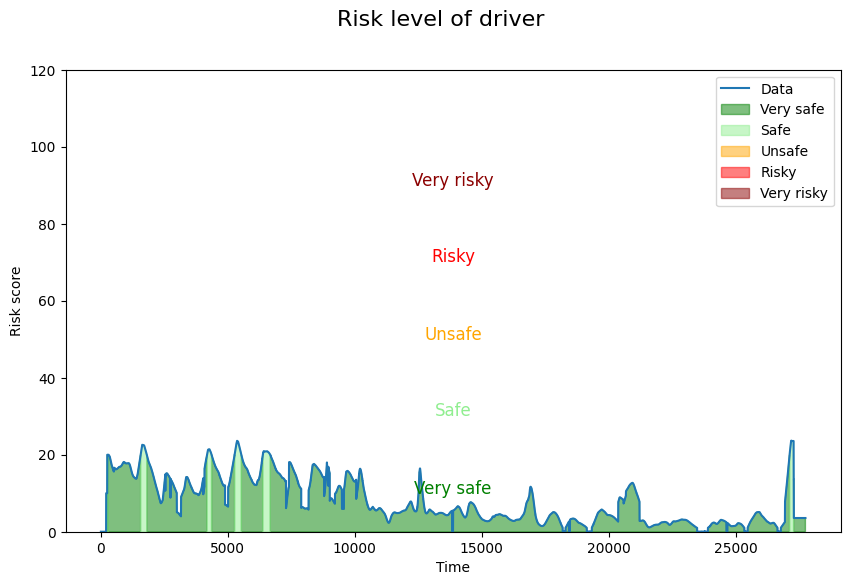

In [11]:
import matplotlib.pyplot as plt


df['driver_risk'].plot(kind='line', figsize=(10, 6), label='Data')


plt.suptitle('Risk level of driver', fontsize=16)  # 主标题


colors = ['green', 'lightgreen', 'orange', 'red', 'darkred']
labels = ['Very safe', 'Safe', 'Unsafe', 'Risky', 'Very risky']
conditions = [
    (df['driver_risk'] <= 20),
    (df['driver_risk'] > 20) & (df['driver_risk'] <= 40),
    (df['driver_risk'] > 40) & (df['driver_risk'] <= 60),
    (df['driver_risk'] > 60) & (df['driver_risk'] <= 80),
    (df['driver_risk'] > 80)
]


for i, condition in enumerate(conditions):
    plt.fill_between(df.index, df['driver_risk'], color=colors[i], where=condition, alpha=0.5, label=labels[i])


label_positions_y = [10, 30, 50, 70, 90]
for i, label in enumerate(labels):
    plt.text(df.index[int(len(df.index) * 0.5)], label_positions_y[i], label, horizontalalignment='center', fontsize=12, color=colors[i])


plt.xlabel('Time')
plt.ylabel('Risk score')
plt.ylim(0, 120)

plt.legend()


plt.show()


## 2)How risky the simulated driving environment is

The risk factor of the driving environment is primarily determined by the distance to the vehicle in front and the behavior of the vehicle behind.
1. If the distance to the vehicle in front is too short, it may lead to a rear-end collision.
2. If the vehicle behind does not brake appropriately, the likelihood of being rear-ended increases.

### Risk level of leading vehicle

In [12]:

#The safety distance considering the reaction time,
safe_distance_map={ 0:0,
                10:2.0,
                20:7.6,
               30:12.7,
               40:19.0,
               50:26.2,
               60:34.4,
               70:43.5,
               80:53.7,
               90:64.9,
               100:77.0,
               120:104.2,
               150:152.4,
               180:209.4,
               200:252.4,
               250:377.0
        }
for index, row in df.iterrows():
    velocity=row['Velocity']*1.6
    gap=999
    for key in safe_distance_map:
        if abs(key-velocity)<gap:
            gap=abs(key-velocity)
            safe_distance=safe_distance_map[key]*velocity/max(1,key)
    if abs(row['YPos']-row['LeadVehPosX'])>2:
        df.at[index, 'risk_leadingCar'] = 0
    elif safe_distance*1.5<row['HeadwayDistance']:
        df.at[index, 'risk_leadingCar'] = 0
    elif safe_distance*1.2<row['HeadwayDistance']:
        df.at[index, 'risk_leadingCar'] = 40
    elif safe_distance<row['HeadwayDistance']:
        df.at[index, 'risk_leadingCar'] = 60
    else:
        df.at[index, 'risk_leadingCar'] = 100


### Risk level of following vehicle

In [13]:
for index, row in df.iterrows():
    if row['FollowCarBrakingStatus']==1:
        df.at[index, 'risk_followingCar'] = 0
    else:
        df.at[index, 'risk_followingCar'] = 20

### Overall risk level of driving environment

In [14]:
for index, row in df.iterrows():
    risk=row['risk_followingCar']+row['risk_leadingCar']
    df.at[index, 'environment_risk'] = risk

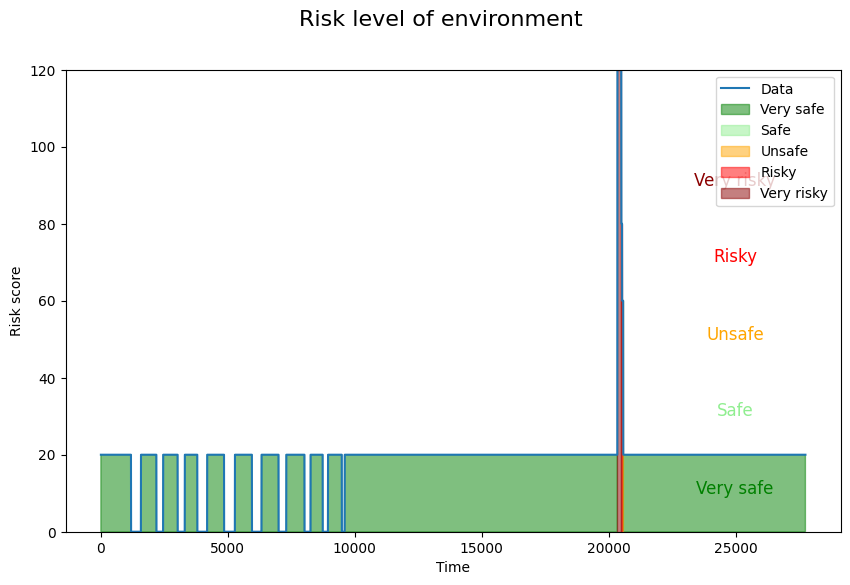

In [15]:
import matplotlib.pyplot as plt


df['environment_risk'].plot(kind='line', figsize=(10, 6), label='Data')


plt.suptitle('Risk level of environment', fontsize=16)  # 主标题


colors = ['green', 'lightgreen', 'orange', 'red', 'darkred']
labels = ['Very safe', 'Safe', 'Unsafe', 'Risky', 'Very risky']
conditions = [
    (df['environment_risk'] <= 20),
    (df['environment_risk'] > 20) & (df['environment_risk'] <= 40),
    (df['environment_risk'] > 40) & (df['environment_risk'] <= 60),
    (df['environment_risk'] > 60) & (df['environment_risk'] <= 80),
    (df['environment_risk'] > 80)
]


for i, condition in enumerate(conditions):
    plt.fill_between(df.index, df['environment_risk'], color=colors[i], where=condition, alpha=0.5, label=labels[i])


label_positions_y = [10, 30, 50, 70, 90]
for i, label in enumerate(labels):
    plt.text(df.index[int(len(df.index) * 0.9)], label_positions_y[i], label, horizontalalignment='center', fontsize=12, color=colors[i])


plt.xlabel('Time')
plt.ylabel('Risk score')
plt.ylim(0, 120)

plt.legend()


plt.show()


## How attentive the driver is

### Count how many times the driver turned head

In [ ]:
import cv2
import dlib
import numpy as np

# Initialize dlib's face detector and facial landmarks predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("/content/gdrive/MyDrive/shape_predictor_68_face_landmarks.dat")

# Open the MP4 video file
cap = cv2.VideoCapture("/content/gdrive/MyDrive/Experimenter_9110002_53.mp4")  # Replace with your video file path

def calculate_angle(points):
    """Calculate the angle between two points."""
    delta_y = points[1][1] - points[0][1]
    delta_x = points[1][0] - points[0][0]
    return np.arctan2(delta_y, delta_x) * 180 / np.pi

# Initial head direction is None
last_direction = None
# Get the frame rate of the video
fps = cap.get(cv2.CAP_PROP_FPS)
# List to record the turning timestamps
turn_timestamps = []

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_number = cap.get(cv2.CAP_PROP_POS_FRAMES)  # Get the current frame number
    current_time = frame_number / fps  # Calculate the current time in seconds

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)
    for face in faces:
        landmarks = predictor(gray, face)

        nose_tip = (landmarks.part(33).x, landmarks.part(33).y)
        chin = (landmarks.part(8).x, landmarks.part(8).y)
        angle = calculate_angle([nose_tip, chin])

        # Determine the direction of the head
        if angle > 10:
            direction = "right"
        elif angle < -10:
            direction = "left"
        else:
            direction = "middle"

        # Detect head turning action (change of direction)
        if last_direction is not None and direction != last_direction:
            turn_timestamps.append(current_time)
            print(f"Turning time: {current_time} seconds")

        last_direction = direction


total_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
video_duration = total_frames / fps
print("Turning timestamps:", turn_timestamps)
if len(turn_timestamps)/min(1,video_duration)<0.1:
    risk_turninghead=0
else:
    risk_turninghead=len(turn_timestamps)/min(1,video_duration)*100*2



Turning timestamps: []



### Evaluating whether the driver maintains a safe distance from the vehicle ahead.

In [ ]:
count_Unsafe = df['environment_risk'].value_counts().get('Unsafe', 0)
count_Risky = df['environment_risk'].value_counts().get('Risky', 0)
count_VeryRisky = df['environment_risk'].value_counts().get('Very risky', 0)


total_count = len(df)
proportion = (count_Unsafe+count_Risky+count_VeryRisky) / total_count
print(proportion)

0.0


### The driver's level of attention while driving.

In [ ]:
attentive=max(0,100-risk_turninghead-10*proportion)
if attentive<=20:
    attention="Distracted"
elif attentive<=40:
    attention="Casual"
elif attentive<=60:
    attention="Attentive"
elif attentive<=80:
    attention="Focused"
else:
    attention="Vigilant"

print("The driver is ",attention)

The driver is  Vigilant


## how drowsy the driver

### Count how many times the driver blinked and determine whether the driver's eyes remain half-closed for an extended period.

In [ ]:
import cv2
import dlib
import numpy as np
from google.colab.patches import cv2_imshow

# Load the facial detector and landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("/content/gdrive/MyDrive/shape_predictor_68_face_landmarks.dat")

# Calculate the Eye Aspect Ratio (EAR)
def eye_aspect_ratio(eye_points):
    A = np.linalg.norm(eye_points[1] - eye_points[5])
    B = np.linalg.norm(eye_points[2] - eye_points[4])
    C = np.linalg.norm(eye_points[0] - eye_points[3])
    ear = (A + B) / (2.0 * C)
    return ear

# Set EAR threshold
EAR_THRESHOLD = 0.2
EAR_CONSEC_FRAMES = 2
blink_counter = 0
frame_counter = 0
sleepy_counter = 0
frame_sum=0
# Initialize the list for blink timestamps
blink_timestamps = []

# Read the video
cap = cv2.VideoCapture("/content/gdrive/MyDrive/Experimenter_9110002_53.mp4")

fps = cap.get(cv2.CAP_PROP_FPS)

while True:
    ret, frame = cap.read()

    frame_number = cap.get(cv2.CAP_PROP_POS_FRAMES)

    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)

    for face in faces:
        landmarks = predictor(gray, face)

        leftEye = np.array([[landmarks.part(n).x, landmarks.part(n).y] for n in range(36, 42)])
        rightEye = np.array([[landmarks.part(n).x, landmarks.part(n).y] for n in range(42, 48)])

        leftEAR = eye_aspect_ratio(leftEye)
        rightEAR = eye_aspect_ratio(rightEye)
        ear = (leftEAR + rightEAR) / 2.0

        if ear < EAR_THRESHOLD:
            frame_counter += 1
        else:
            if frame_counter >= EAR_CONSEC_FRAMES:
                blink_counter += 1
                # Record the timestamp of the blink
                timestamp = frame_number / fps
                blink_timestamps.append(timestamp)
                print(f"Blink at {timestamp:.2f} seconds.")
            frame_counter = 0

        if ear < 0.28:
            sleepy_counter += 1
        frame_sum += 1


print("Blink timestamps (in seconds):", blink_timestamps)
print("Sleepy ratio:", sleepy_counter/frame_sum)

if sleepy_counter/frame_sum<=0.2:
    print("The driver is alert")
elif sleepy_counter/frame_sum<=0.4:
    print("The driver is tired")
else:
    print("The driver is exhausted")

Blink at 2.60 seconds.
Blink at 2.77 seconds.
Blink at 7.70 seconds.
Blink at 7.73 seconds.
Blink at 8.36 seconds.
Blink at 10.60 seconds.
Blink at 11.40 seconds.
Blink at 13.73 seconds.
Blink at 13.96 seconds.
Blink at 18.93 seconds.
Blink at 19.79 seconds.
Blink at 22.26 seconds.
Blink at 31.12 seconds.
Blink at 45.88 seconds.
Blink at 46.98 seconds.
Blink at 50.98 seconds.
Blink at 57.08 seconds.
Blink at 58.41 seconds.
Blink at 58.51 seconds.
Blink at 71.47 seconds.
Blink at 72.97 seconds.
Blink at 84.50 seconds.
Blink at 92.96 seconds.
Blink at 99.46 seconds.
Blink at 101.13 seconds.
Blink at 111.26 seconds.
Blink at 112.32 seconds.
Blink at 116.55 seconds.
Blink at 118.82 seconds.
Blink at 121.35 seconds.
Blink at 123.12 seconds.
Blink at 124.55 seconds.
Blink at 129.95 seconds.
Blink at 131.45 seconds.
Blink at 132.31 seconds.
Blink at 137.44 seconds.
Blink at 153.64 seconds.
Blink at 154.54 seconds.
Blink at 155.44 seconds.
Blink at 156.14 seconds.
Blink at 157.60 seconds.
Blin

In [ ]:
df.to_csv('output.csv', index=False)